In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector

In [3]:
# Get recent housing data
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/" 
HOUSING_PATH = "datasets/housing" 
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz" 

def fetchHousingData(housingURL=HOUSING_URL, housingPath=HOUSING_PATH): 
    if not os.path.isdir(housingPath): 
        os.makedirs(housingPath) 
        tgzPath = os.path.join(housingPath, "housing.tgz") 
        urllib.request.urlretrieve(housingURL, tgzPath) 
        housingTgz = tarfile.open(tgzPath) 
        housingTgz.extractall(path=housingPath) 
        housingTgz.close()

fetchHousingData(HOUSING_URL, HOUSING_PATH)

In [4]:
def loadHousingData(housingPath = HOUSING_PATH): 
    csvPath = os.path.join(housingPath, "housing.csv")
    return pd.read_csv(csvPath)

housing = loadHousingData(HOUSING_PATH)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


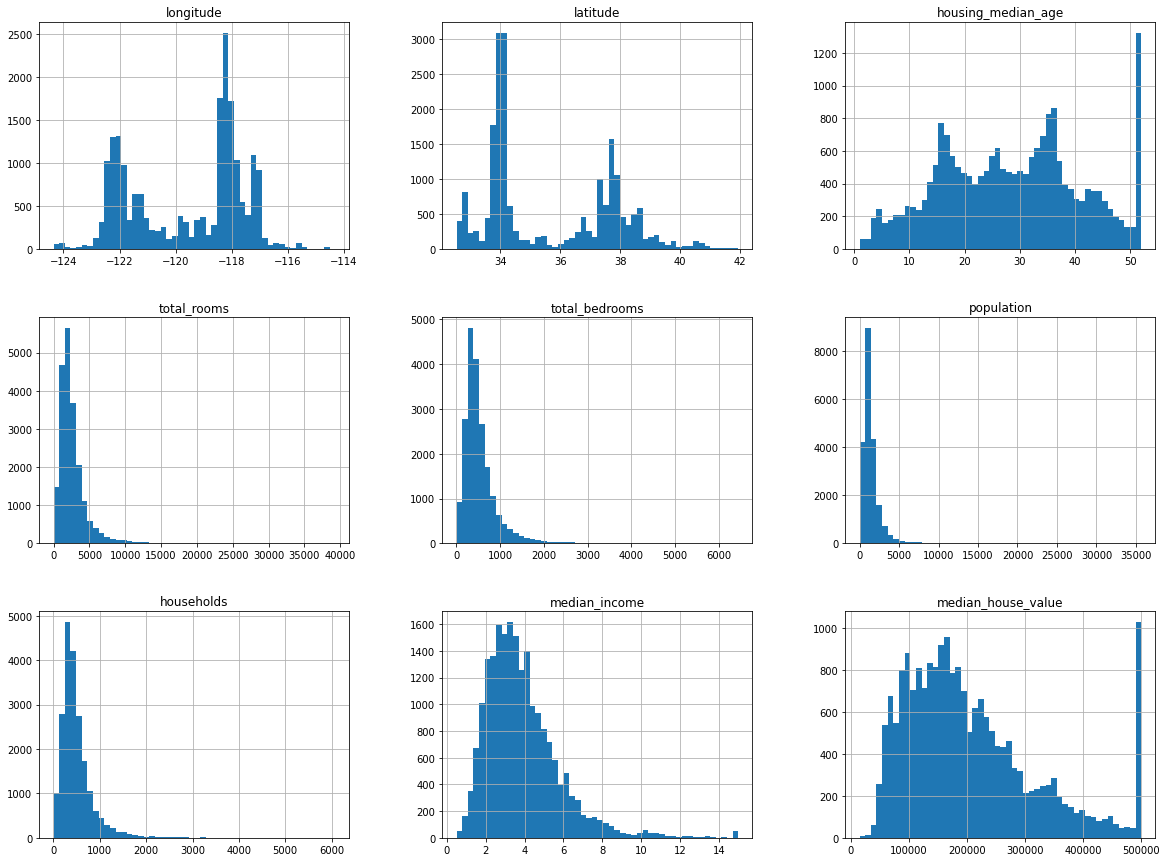

In [8]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

# Creating the Test Set (Prevent Data Snooping Bias)

In [9]:
# DONT USE THIS. This will generate new values each time the program runs, which we don't want

# def splitTrainTest(data, testRatio): 
#     shuffledIndices = np.random.permutation(len(data))
#     testSetSize = int(len(data) * testRatio)
#     testIndices = shuffledIndices[:testSetSize]
#     trainIndices = shuffledIndices[testSetSize:]
#     return data.iloc[trainIndices], data.iloc[testIndices]

In [10]:
# trainSet, testSet = splitTrainTest(housing, 0.2)
# print(len(trainSet), "train +", len(testSet), "test")

In [11]:
# Not sure what this function does
def testSetCheck(identifier, testRatio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * testRatio

In [12]:
# Not sure what this function does
def splitTrainTestId(data, testRatio, idColumn, hash = hashlib.md5):
    ids = data[idColumn]
    inTestSet = ids.apply(lambda id_: testSetCheck(id_, testRatio, hash))
    return data.loc[~inTestSet], data.loc[inTestSet]

In [13]:
# Adding an identifier column to the housing dataset. 
# However, once we recall the data we need to be careful because the row ids might not be the same
housingWithId = housing.reset_index()
# trainSet, testSet = splitTrainTestId(housingWithId, 0.2, "index")

In [14]:
# We need a stable unique identifier for each row i.e one that will not change
# To achieve this, we can use a district's latitude and longtitude

housingWithId["id"] = housing["longitude"] * 1000 + housing["latitude"]
trainSet, testSet = splitTrainTestId(housingWithId, 0.2, "index")

In [15]:
# SciKit has some built in features such as train_test_split: 

trainSet, testSet = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
trainSet

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0,<1H OCEAN
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0,INLAND
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN


In [17]:
testSet

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
15362,-117.22,33.36,16.0,3165.0,482.0,1351.0,452.0,4.6050,263300.0,<1H OCEAN
16623,-120.83,35.36,28.0,4323.0,886.0,1650.0,705.0,2.7266,266800.0,NEAR OCEAN
18086,-122.05,37.31,25.0,4111.0,538.0,1585.0,568.0,9.2298,500001.0,<1H OCEAN
2144,-119.76,36.77,36.0,2507.0,466.0,1227.0,474.0,2.7850,72300.0,INLAND


In [18]:
# Instead of using random sampling methods e.g. If you have a small dataset, you want the sample to be representative of the population. So for example, 51.3% of the US population = Female, 48.7% are male. When a survey is conducted with a 1000 people, we can use STRATIFIED SAMPLING
# This means we should have 513 females, 487 males
# The population is split into homogeneous subgroups (stratas)
# Suppose for this example, experts say that the median income is a very important attribute to preddict median housing prices. Then, we may want to ensure that the test set is representative of the different categories of income. 
# Look at median income histogram: 

<AxesSubplot:>

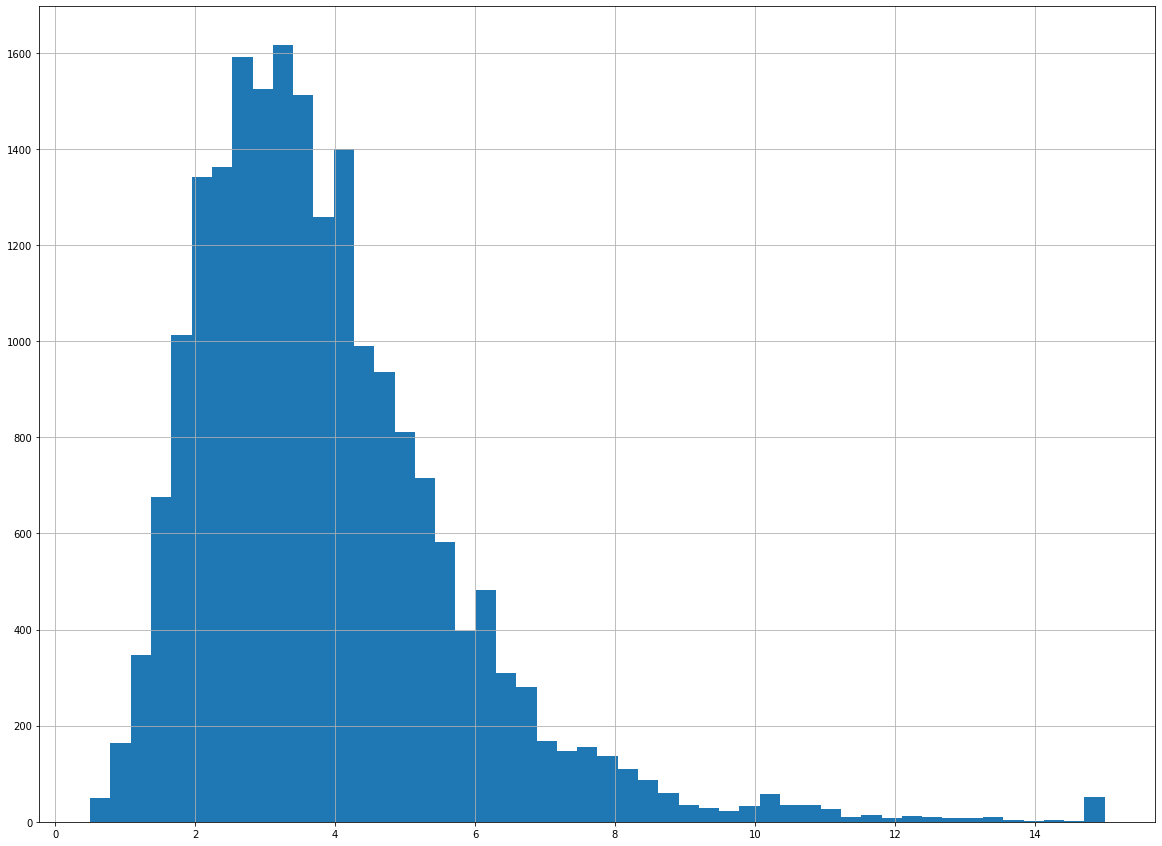

In [19]:
housing["median_income"].hist(bins=50, figsize=(20,15))

In [20]:
# Create an income category attribute byb deviding median income by 1.5 (to limit number of income categories) and then round up using .ceil and then merge all categories greater than 5 into category 5
housing["incomeCat"] = np.ceil(housing["median_income"] / 1.5)
housing["incomeCat"].where(housing["incomeCat"] < 5, 5.0, inplace=True)

In [21]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for trainIndex, testIndex in split.split(housing, housing["incomeCat"]): 
    stratTrainSet = housing.loc[trainIndex]
    stratTestSet = housing.loc[testIndex]

In [22]:
housing["incomeCat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: incomeCat, dtype: float64

In [23]:
# If we compare this data with the data for our original dataset, we can see in the stratified model, the ratios are kept every similar which is GOOD! This means we are getting a good sample of test data
# If we compare with the random sampling method, the ratios are not kept the same. 

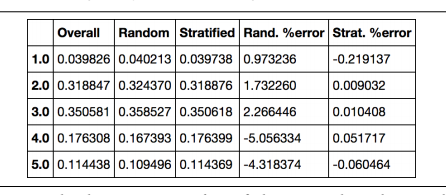

In [24]:
# Now we can remove the income category to return the data back to its original state
for set in (stratTrainSet, stratTestSet): 
    set.drop(["incomeCat"], axis=1, inplace=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

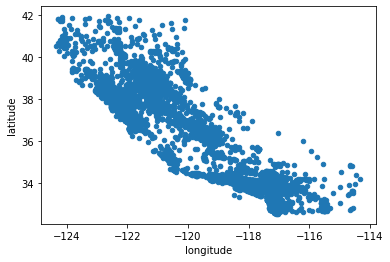

In [25]:
housing = stratTrainSet.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

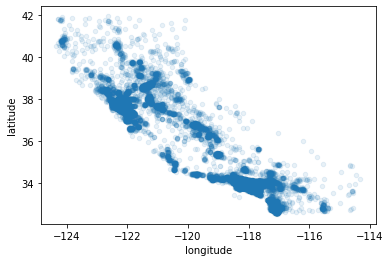

In [26]:
# While we can clearly see this is California, we can't see much about particularly densities of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

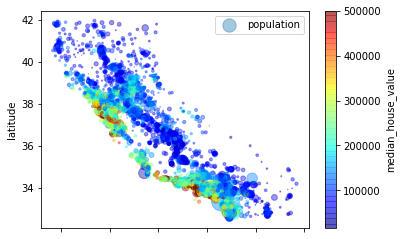

In [27]:
# Housing Prices: The radius of each circle represents the district's population (s) and the colour represents the price (c)
# The colourmap (cmap) we use is called jet whcih ranges from blue for low vals to red for high vals

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing['population']/100, label='population', 
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            )
plt.legend()

In [28]:
# As we can see, the price of the housing is very much related to the location. Houses near the ocean tend to cost more than houses inland. 

# Looking for Correlations

In [29]:
# Computing the Standard Correlation Coefficient between every pair of attributes: 
corrMatrix = housing.corr()
corrMatrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [30]:
# So we can see how closely related each parameter is to the median house price
# The closer the correlation co-efficient is to 1, the stronger the correlation
# The median_income has the strongest positive correlation. 

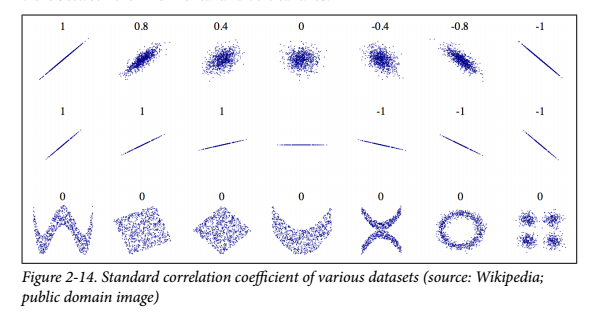

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

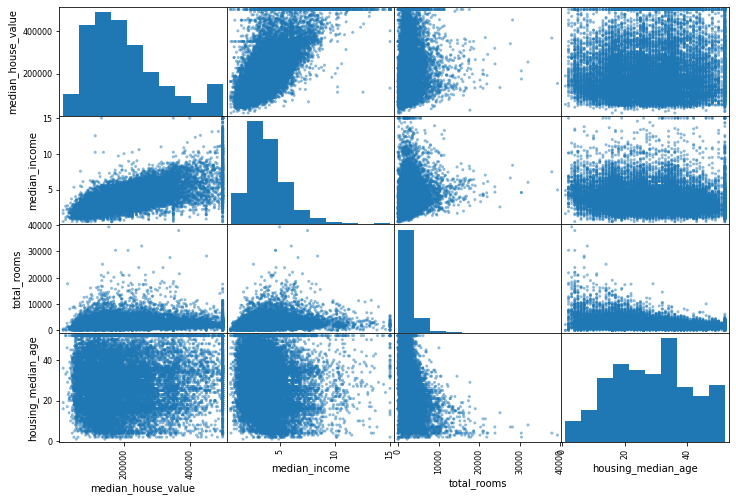

In [31]:
# Notice how a correlation co-efficient of 0 does not necessarily mean there is no relationship between the 2 axes
# Another way to check for correlation is to use the Pandas' scatter_matrix function which plots each attribute against each other attribute
# Since we have 11 attributes, we would get each 11 attribute plotted against each other i.e. 11^2 = 121 plots!
# Let's look at the most important attributes
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

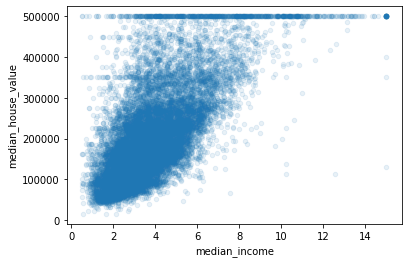

In [32]:
# In the middle diagonal, instead of plotting each attribute against itself, pandas plots just that attribute as a histogram
# It looks like the median income is the best measure: 
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [33]:
# The horizontal line comes from the price cap we put in place before
# But there is also a horizontal line at 450,000 and 350,0000. 
# To get rid of these we can remove those districts to prevent the system from picking up these traits

In [34]:
# Now, we can try some various attribute combinations. The number of rooms isn't useful by itself, however the number of rooms PER HOUSEHOLD might be useful.
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [35]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [36]:
# As we can see, the bedrooms_per_room is much more correlated than simply bedrooms or rooms
# Even though it is a negative correlation, this is still good

In [37]:
# Revert to clean training set: 
housing = stratTrainSet.drop("median_house_value", axis=1)
housingLabels = stratTrainSet["median_house_value"].copy()

# Data Cleaning

In [38]:
# We know that the 'total bedrooms' attributes has some missing values.
# Let's fill in these values with the median: 
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
          ...  
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Length: 16512, dtype: float64

In [39]:
# Another way, is using the impute Method provided by scikit
imputer = SimpleImputer(strategy="median")

In [40]:
# Since the median can only be computed on numerical attribites, we have to drop the ocean proximity column: 
housingNumerical = housing.drop("ocean_proximity", axis=1)

In [41]:
imputer.fit(housingNumerical)

SimpleImputer(strategy='median')

In [42]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [43]:
housingNumerical.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [44]:
# Now we can replace blanks with the imputer's median's: 
X = imputer.transform(housingNumerical)
housingTr = pd.DataFrame(X, columns=housingNumerical.columns)

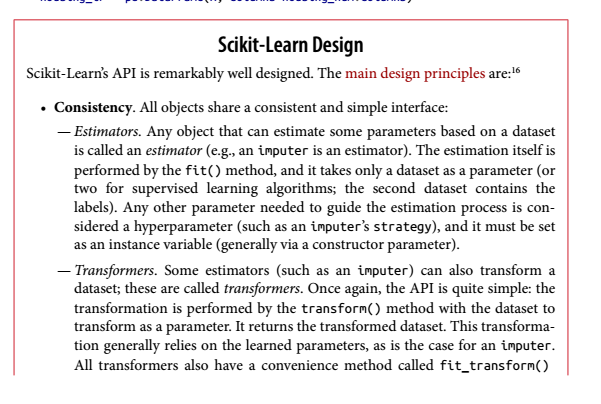
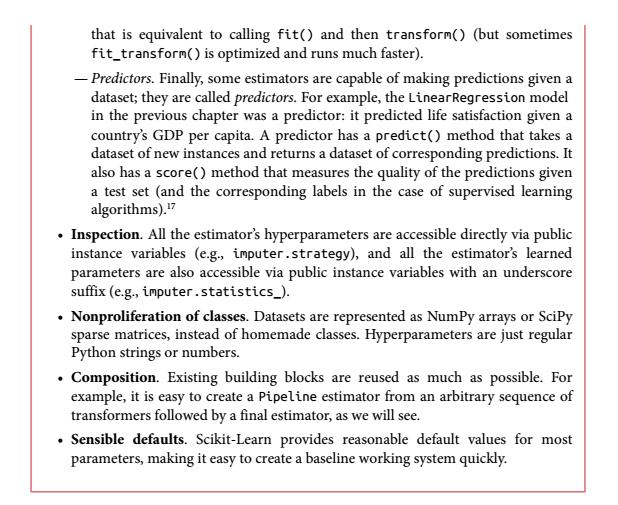

# Handling Text and Categorical Attributes

In [45]:
# Convert Ocean_proximity values to numbers.
encoder = LabelEncoder()
housingCat = housing["ocean_proximity"]
housingCatEncoded = encoder.fit_transform(housingCat)
housingCatEncoded

array([0, 0, 4, ..., 1, 0, 3])

In [46]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [47]:
# One issue with this is that the ML algorithm will assume that 2 nearby values e.g. 0 and 1 are close to each other. This is not the case. 
# To fix this, we can use one-hot encoding

In [48]:
encoder = OneHotEncoder()
housingCat1Hot = encoder.fit_transform(housingCatEncoded.reshape(-1,1))
housingCat1Hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [49]:
# Sparse matrices use up less memory than a traditional array. Remember, all the rows will be filled with 0s apart from a single 1 per row. A sparse matrix only stores the indices of those ones.

In [50]:
# We can apply both transformations - from text to integer then integer to one hot vectors in one move using the LabelBinarizer
encoder = LabelBinarizer()
housingCat1Hot = encoder.fit_transform(housingCat)
housingCat1Hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [51]:
# Notice how this returns an array instead of a sparse matrix. Instead, we can: 
encoder = LabelBinarizer(sparse_output=True)
housingCat1Hot = encoder.fit_transform(housingCat)
housingCat1Hot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

# Custom Transformers

In [52]:
# To create custom transformers, all we have to do is create a class and implement 3 methods: 
# fit()
# transform()
# fit_transform() = This can be obtained by simply addinge TransformerMixin as a base class
# If we add baseEstimator as a base class (and avoid *args, **kargs in our constructor) we can get 2 extra methods: 
# get_params() and set_params() that will be useful for automatic hyperparameter tuning
# Here is a transfomrer class that adds the combined attributes we did earlier:

In [53]:
roomsIx, bedroomsIx, populationIx, householdIx = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, addBedroomsPerRoom = True): #No args or kargs
        self.addBedroomsPerRoom = addBedroomsPerRoom
    def fit(self, X, y=None):
        return self #Nothing Happens Here
    def transform(self, X, y=None):
        roomsPerHousehold = X[:, roomsIx] / X[:, householdIx]
        populationPerHousehold = X[:, populationIx] / X[:, householdIx]
        if self.addBedroomsPerRoom: 
            bedroomsPerRoom = X[:, bedroomsIx] / X[:, roomsIx]
            return np.c_[X, roomsPerHousehold, populationPerHousehold, bedroomsPerRoom]
        else: 
            np.c_[X, roomsPerHousehold, populationPerHousehold]
            
attributeAdder = CombinedAttributesAdder(addBedroomsPerRoom = False)
housingExtraAttributes = attributeAdder.transform(housing.values)
# We have purposely added the hyperparameter since we are not sure about how useful the Bedrooms per Room parameter is. This way we can tweak it and see if it makes a difference to our model. 

# Feature Scaling

In [54]:
# ML algorithms don't usually perform well when the numerical attributes have different scales
# For the housing data, the scale for the number of rooms ranges from 6 to 39,320 while the median incomes only range from 0 to 15
# Scaling the target value is usually not required
# There are 2 ways to get the correct scales: 
# min-max scaling (normalisation) and standardization

In [55]:
# Normalisation = Values are shifted and rescaled so that they end up ranging from 0 to 1.
# We do this by subtracting the min and dividing by the max-min. SciKit has a transformer for this (MinMaxScaler)
# Standardisation = First it subtracts the mean value (so Standardised values always have 0 mean) and then divides by teh variance so that resulting distribution has unit variance. 
# But Standardisation does not bound values to a specific range which is Bad. However it is good, because it is less affected by outliers. SciKit has a transformer for this (StandardScaler)

# Tranformation Pipelines

In [56]:
# We can make a pipeline for the transformations
numPipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('attributeAdder', CombinedAttributesAdder()), 
    ('stdScaler', StandardScaler())
])
housingNumTr = numPipeline.fit_transform(housingNumerical)

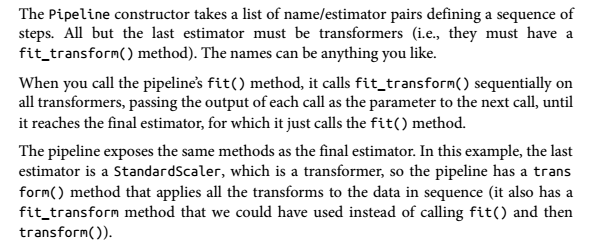

In [57]:
# But we also need to join the LabelBinarizer on the categorical values. To do this, we can use the FeatureUnion class. 

# Full Pipeline

In [58]:
from sklearn.base import TransformerMixin #gives fit_transform method for free
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [59]:
numAttribs = list(housingNumerical)
catAttribs = ["ocean_proximity"]

numPipeline = Pipeline([
    ('selector', DataFrameSelector(numAttribs)),
    ('imputer', SimpleImputer(strategy="median")), 
    ('attributeAdder', CombinedAttributesAdder()), 
    ('stdScaler', StandardScaler()),
])

catPipeline = Pipeline([
    ('selector', DataFrameSelector(catAttribs)),
    ('labelBinarizer', MyLabelBinarizer()),
])

fullPipeline = FeatureUnion(transformer_list=[
    ("numPipeline", numPipeline), 
    ("catPipeline", catPipeline),
])

In [60]:
housingPrepared = fullPipeline.fit_transform(housing)

In [61]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [62]:
housingPrepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [63]:
housingPrepared.shape

(16512, 16)

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributeNames):
        self.attributeNames = attributeNames
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributeNames].values

# Training and Evaluating on the Training Set

In [65]:
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg.fit(housingPrepared, housingLabels)

LinearRegression()

In [66]:
someData = housing.iloc[:5]
someLabels = housingLabels.iloc[:5]
someDataPrepared = fullPipeline.transform(someData)
print("Predictions:\t", linReg.predict(someDataPrepared))

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [67]:
print("Labels:\t\t", list(someLabels))

Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [68]:
# Let's measure the model's RMSE on the whole training set using SciKit Learn's mean squared error function:
from sklearn.metrics import mean_squared_error
housingPredictions = linReg.predict(housingPrepared)
linMSE = mean_squared_error(housingLabels, housingPredictions)
linRMSE = np.sqrt(linMSE)
linRMSE

68628.19819848922

In [69]:
# So, the typical prediction error is about $68,000 dollars - which is way too high
# It looks like the model is underfitting the training data i.e the features don't provide enough info
# To fix this, we can select a more powerful model or reduce constraints on the model
# The model is not regularised, so we can't reduce constraints
# We could try to add more features, but let's try a more powerful model first

In [70]:
from sklearn.tree import DecisionTreeRegressor
treeReg = DecisionTreeRegressor()
treeReg.fit(housingPrepared, housingLabels)

DecisionTreeRegressor()

In [71]:
housingPredictions = treeReg.predict(housingPrepared)
treeMSE = mean_squared_error(housingLabels, housingPredictions)
treeRMSE = np.sqrt(treeMSE)
treeRMSE

0.0

In [72]:
# Wait What? This means there is no error at all! This is probably because we have overfit the data massively. Let's test on a small part of the test set (we don't want to use the whole test set yet)

# Better Evaluations Using Cross-Validation

In [73]:
# Let's use the train_test_split function to split the testing set into a smaller training set and a validation set: 
# OR:

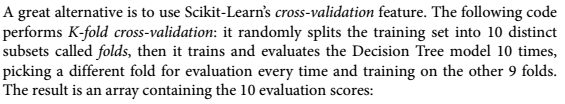

In [74]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(treeReg, housingPrepared, housingLabels, scoring="neg_mean_squared_error", cv=10)
RMSEScores = np.sqrt(-scores)

In [75]:
def displayScores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
displayScores(RMSEScores)

Scores: [68503.91517441 64640.87673787 70857.11100297 68989.52544581
 69741.32595017 74846.97644545 70882.67619648 71351.83982689
 75883.79227014 71579.90212041]
Mean: 70727.79411706018
Standard Deviation: 3011.6293027593383


In [76]:
# This is worse than the linear regression model! The tree has a score of approx 71,200
# Generally + or - 3200. 

In [77]:
# Let's compute the scores for the Linear Regression Model too: 
linScores = cross_val_score(linReg, housingPrepared, housingLabels, 
                            scoring="neg_mean_squared_error", cv=10)
linRMSEScores=np.sqrt(-linScores)
displayScores(linRMSEScores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.6740017983493


In [78]:
# This shows the Decision Tree Model is badly overfitting the data
# Let's try the Random Forest Model which trains many Decision Trees on a random subset of the features then averages out the predictions
# Building models on top of each other = Ensemble Learning

In [79]:
from sklearn.ensemble import RandomForestRegressor
forestReg = RandomForestRegressor()
forestReg.fit(housingPrepared, housingLabels)
housingPredictions = forestReg.predict(housingPrepared)
forestMSE = mean_squared_error(housingLabels, housingPredictions)
forestRMSE = np.sqrt(forestMSE)

In [80]:
scores = cross_val_score(forestReg, housingPrepared, housingLabels, scoring="neg_mean_squared_error", cv=10)
RMSEScores = np.sqrt(-scores)

In [81]:
displayScores(RMSEScores)

Scores: [49310.50332492 47628.85119511 49731.66735983 52063.25268941
 49841.74463177 53670.60964953 48770.81370949 48178.9897682
 52993.70900862 50422.12884188]
Mean: 50261.227017876074
Standard Deviation: 1928.9959664704502


In [82]:
# The scores on the training set is much lower than on the validation sets meaning that the model is still overfitting the training set
# We can try a few other models

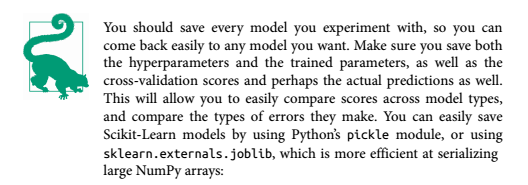

In [83]:
# from sklearn.externals import joblib
# joblib.dump(myModel, "myModel.pkl")
# # and later
# myModelLoaded = joblib.load("myModel.pkl")

# Grid Search

In [87]:
# Tweaking the Hyperparameters to obtain most accurate model
from sklearn.model_selection import GridSearchCV

paramGrid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]}, 
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]}, 
]

forestReg = RandomForestRegressor()

gridSearch = GridSearchCV(forestReg, paramGrid, cv=5, 
                         scoring='neg_mean_squared_error')
gridSearch.fit(housingPrepared, housingLabels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

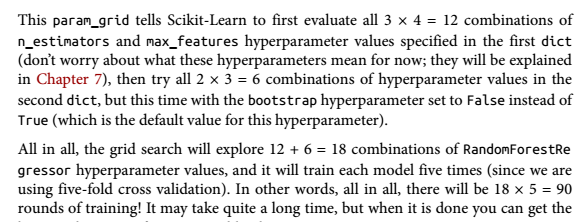

In [88]:
gridSearch.best_params_

{'max_features': 6, 'n_estimators': 30}

In [91]:
# Since 30 was the max n_estimator we tried, we can evaluate higher values
paramGrid = [
    {'n_estimators': [3,10,100], 'max_features': [2,4,6,8]}, 
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]}, 
]

forestReg = RandomForestRegressor()

gridSearch = GridSearchCV(forestReg, paramGrid, cv=5, 
                         scoring='neg_mean_squared_error')
gridSearch.fit(housingPrepared, housingLabels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [92]:
gridSearch.best_params_

{'max_features': 8, 'n_estimators': 100}

In [94]:
# We can get the best estimator directly: 
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None, max_features=6, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1, oob_score=False, random_state=None, verbose=0, warm_start=False)

RandomForestRegressor(max_features=6, n_jobs=1)

In [95]:
# The evaluation scores: 
cvres = gridSearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63601.04623498174 {'max_features': 2, 'n_estimators': 3}
55156.355226969994 {'max_features': 2, 'n_estimators': 10}
51852.85781550412 {'max_features': 2, 'n_estimators': 100}
59334.26283793777 {'max_features': 4, 'n_estimators': 3}
53036.095323199355 {'max_features': 4, 'n_estimators': 10}
49784.869538989646 {'max_features': 4, 'n_estimators': 100}
58684.15155498942 {'max_features': 6, 'n_estimators': 3}
52086.96535862079 {'max_features': 6, 'n_estimators': 10}
49374.667858787056 {'max_features': 6, 'n_estimators': 100}
58929.52804806883 {'max_features': 8, 'n_estimators': 3}
51945.89963665663 {'max_features': 8, 'n_estimators': 10}
49238.91060140789 {'max_features': 8, 'n_estimators': 100}
61985.54163168897 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54293.109570821536 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60063.814764936906 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52542.56593083127 {'bootstrap': False, 'max_features': 3, 'n_estim

In [96]:
# As we can see, the best score comes when we set the max_features hyperparameter to 6 and the n_estimators parameter to 30

In [97]:
# The grid search approach works for few combinations, but when we want to explore lots of combos, we can use RandomizedSearchCV instead.
# Instead of trying all the combinations, it tries out random combinations by trying random values for each hyperparameter at every iteration: 
# Benefits:
# If you let the search run for e.g. 1000 iterations, the appoach will explore 1000 values for EACH hyperparameter instead of just a few values per hyperparameter (gridsearch)
# You have more control over how much computer budget you want to allocate to the hyperparameter search

# Ensemble Methods

In [99]:
# Now we can evaluate the model on our test set. 

finalModel = gridSearch.best_estimator_ 

XTest = stratTestSet.drop("median_house_value", axis=1)
YTest = stratTestSet["median_house_value"].copy()
XTestPrepared = fullPipeline.transform(XTest)

finalPredictions = finalModel.predict(XTestPrepared)

finalMSE = mean_squared_error(YTest, finalPredictions)
finalRMSE = np.sqrt(finalMSE)

In [100]:
finalRMSE

47221.89888926079